## Analisis Sentimen Depresi Pengguna Aplikasi X dengan Menggunakan Algoritma LSTM

Kelompok 1:
*   Anita Nursi
*   Ilham Bariq Fauzan
*   Nicholas Ryan Jonathan
*   Rizky Pamuji

Sumber Dataset:
[Sentimental Analysis Tweets](https://www.kaggle.com/datasets/gargmanas/sentimental-analysis-for-tweets)







###Latar Belakang

Depresi adalah kondisi kesehatan mental yang serius yang dapat memengaruhi perasaan, pikiran, dan perilaku seseorang. Dengan meningkatnya penggunaan media sosial, banyak orang mengekspresikan perasaan mereka secara online, memberikan peluang untuk mendeteksi tanda-tanda depresi melalui analisis teks. Algoritma Long Short-Term Memory (LSTM) dalam bidang pemrosesan bahasa alami (NLP) telah terbukti efektif dalam menangkap pola bahasa yang menunjukkan kondisi emosional seseorang, menjadikannya alat yang potensial untuk analisis sentimen depresi.

###Tujuan

1.   **Mengembangkan Model LSTM**: Membuat dan melatih model LSTM untuk mengidentifikasi dan mengklasifikasikan sentimen teks pengguna yang mengindikasikan depresi.
2.   **Evaluasi Kinerja Model**: Mengukur akurasi dari model dalam mengklasifikasikan tingkat depresi berdasarkan teks.
3. **Meningkatkan Kesadaran Kesehatan Mental**: Memfasilitasi deteksi dini tanda-tanda depresi melalui analisis sentimen, yang dapat membantu dalam memberikan intervensi yang lebih cepat.








###Pendekatan

Penelitian ini menggunakan algoritma LSTM untuk analisis sentimen depresi. Langkah-langkahnya meliputi:

1. **Pengumpulan Data**: Mengumpulkan data teks dari platform media sosial yang mengandung ekspresi emosional.
2. **Pemrosesan Awal Data**: Melakukan pembersihan data, tokenisasi, dan konversi teks ke dalam vektor numerik menggunakan teknik embedding.
3. **Pengembangan Model LSTM**: Membangun model dengan lapisan embedding, LSTM, dan Dense untuk klasifikasi sentimen.
4. **Pelatihan dan Evaluasi**: Melatih model menggunakan data latih dan mengevaluasi kinerjanya dengan data uji.

###Hipotesis

1. **Efektivitas LSTM**: Algoritma LSTM mampu mengidentifikasi dan mengklasifikasikan sentimen teks dengan tingkat akurasi yang tinggi, terutama dalam mendeteksi tanda-tanda depresi.
2. **Pola Bahasa**: Pengguna yang mengalami depresi akan menunjukkan pola bahasa tertentu yang dapat dikenali oleh model LSTM, memungkinkan deteksi depresi secara lebih akurat.

Dengan menguji hipotesis ini, penelitian ini bertujuan untuk memberikan kontribusi signifikan dalam bidang analisis sentimen dan kesehatan mental.

### Import Library

In [1]:
# Mengimpor library yang dibutuhkan dalam project
import gdown
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

### Eksplorasi Dataset

In [2]:
# Fungsi untuk memuat data csv dari google drive
def load_data_from_gdrive(file_id, output):
    # URL untuk mengunduh file dari Google Drive
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, output, quiet=False)
    df = pd.read_csv(output, index_col=0)
    return df

In [3]:
# Variabel file-id dan output dari dataset di gdrive
file_id = '1DkKUAh97vgL8ptU00WPmYy9aqJFuQEcN'
output = 'sentiment_tweets3.csv'

In [4]:
# Memanggil fungsi untuk mengambil dataset
df = load_data_from_gdrive(file_id, output)

Downloading...
From: https://drive.google.com/uc?id=1DkKUAh97vgL8ptU00WPmYy9aqJFuQEcN
To: /content/sentiment_tweets3.csv
100%|██████████| 1.08M/1.08M [00:00<00:00, 15.7MB/s]


In [5]:
df.head()

,message to examine,label
Index,,
106,just had a real good moment. i missssssssss hi...,0
217,is reading manga http://plurk.com/p/mzp1e,0
220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
288,@lapcat Need to send 'em to my accountant tomo...,0
540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [6]:
# Cetak jumlah baris
print("Jumlah baris:", len(df))

Jumlah baris: 10314


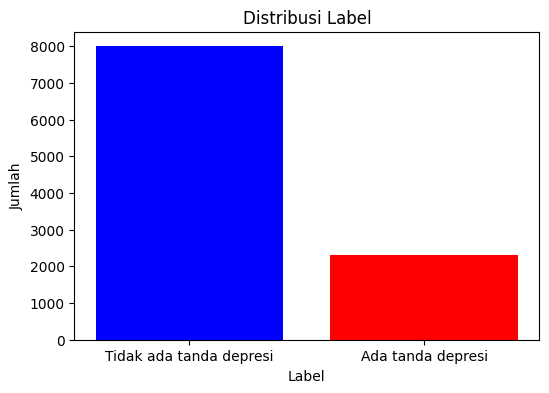

In [7]:
# Visualisasi distribusi label
def plot_label_distribution(df):
    label_counts = df['label'].value_counts()
    plt.figure(figsize=(6, 4))
    plt.bar(label_counts.index, label_counts.values, color=['blue', 'red'])
    plt.xlabel('Label')
    plt.ylabel('Jumlah')
    plt.title('Distribusi Label')
    plt.xticks([0, 1], ['Tidak ada tanda depresi', 'Ada tanda depresi'])
    plt.show()

plot_label_distribution(df)

### Preprocessing Data

Pada bagian ini, data pada kolom `message to examine` akan melalui preprocessing untuk mempersiapkan data dengan cara:
1. Menghapus URL yang terdapat pada dataset
2. Menghapus tag pengguna X yang dimention oleh pengguna lain
3. Menghapus karakter khusus selain alfabet
4. Mengubah semua karakter menjadi huruf kecil
5. Menghapus spasi di sekitar teks
6. Menghapus baris dengan nilai kosong
7. Mereset index

In [8]:
# Mendefinisikan fungsi untuk melakukan preprocessing data
def preprocess_text(text):
    # Menghapus URL
    text = re.sub(r'http\S+', '', text)

    # Menghapus tag pengguna Twitter (@username)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)

    # Menghapus karakter khusus
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Konversi teks menjadi lowercase
    text = text.lower()

    # Menghapus spasi di sekitar teks
    text = text.strip()

    return text

In [9]:
# Menerapkan preprocessing data pada kolom 'message to examine'
df['message to examine'] = df['message to examine'].apply(preprocess_text)

In [10]:
# Memeriksa nilai kosong atau spasi
df['message to examine'].replace('', np.nan, inplace=True)

In [11]:
# Menghapus baris dengan nilai kosong dan mereset index
df.dropna(subset=['message to examine'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [12]:
# Cetak jumlah baris setelah penghapusan
print("Jumlah baris setelah penghapusan:", len(df))

Jumlah baris setelah penghapusan: 10286


In [13]:
df.head()

,message to examine,label
0,just had a real good moment i missssssssss him...,0
1,is reading manga,0
2,need to send em to my accountant tomorrow oddl...,0
3,add me on myspace myspacecomlookthunder,0
4,so sleepy good times tonight though,0


### Tokenisasi dan Padding
Pada bagian ini, akan dilakukan tokenisasi dan padding. Tokenisasi adalah proses membuat urutan numerik pada kata dalam kolom `message to examine` untuk menangani struktut kalimat. Padding adalah proses untuk menyamakan panjang urutan numerik dari hasil tokenisasi sebelumnya untuk menjaga konsistensi input kalimat.

Sebelumnya terdapat parameter dan hyperparameter yang digunakan pada proses-proses berikutnya:
1. `vocab_size` : menentukan jumlah maksimum kata yang akan dimasukkan ke dalam kosakata model. Hanya kata-kata yang paling sering muncul dalam data pelatihan yang akan dimasukkan ke dalam kosakata ini.
2. `embedding_dim` : menentukan ukuran dari vektor embedding yang akan digunakan untuk mewakili setiap kata agar dapat membantu model memahami hubungan antar kata dalam ruang vektor.
3. `max_length` : menentukan panjang maksimum urutan kata yang akan diproses oleh model. Jika sebuah teks atau urutan kata lebih panjang dari max_length, teks tersebut akan dipotong (truncated) untuk memastikan semua input ke model memiliki panjang yang sama, yang penting untuk efisiensi dalam pemrosesan batch.
4. `trunc_type` : mengatur bagaimana urutan yang lebih panjang dari max_length akan dipotong.
5. `oov_tok` : token yang digunakan untuk mewakili kata-kata yang tidak termasuk dalam kosakata (vocab_size) sehingga membantu model menangani kata-kata yang tidak dikenal selama pelatihan atau inferensi.


In [14]:
# Parameter dan Hyperparameter
vocab_size = 10000      # Ukuran kosakata minimum
embedding_dim = 16      # Dimensi vektor embedding
max_length = 120        # Panjang maksimum setelah padding
trunc_type = 'post'     # Memotong akhir urutan yang melebihi max_length
oov_tok = "<OOV>"       # Token kata-kata tidak dalam kosakata

In [15]:
# Melakukan tokenisasi (urutan numerik)
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(df['message to examine'])

# Melakukan padding (menyamakan panjang urutan numerik)
sequences = tokenizer.texts_to_sequences(df['message to examine'])
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

### Pembagian Data Training dan Test
`label` akan dipisahkan dari dataframe selanjutnya dataset akan dibagi dengan rasio 80:20 menggunakan fungsi `train_test_split`.

In [16]:
# Memisahkan 'label' dari dataframe
labels = df['label'].tolist()
labels = np.array(labels)

# Membagi dataset menjadi data training dan data test dengan rasio 80:20
X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42)

In [17]:
# Menampilkan jumlah sampel dalam masing-masing dataset
print(f"Jumlah sampel dalam data training: {len(X_train)}")
print(f"Jumlah sampel dalam data testing: {len(X_test)}")

Jumlah sampel dalam data training: 8228
Jumlah sampel dalam data testing: 2058


### Pembuatan Model

Model Long-Short Term Memory dibuat menggunakan Keras yang merupakan bagian dari TensorFlow. Model dibuat secara sequential (linier). Dapat dilihat model terdiri dari 4 layer:
1. Layer embedding, untuk mengonversi setiap kata dalam urutan input menjadi vektor berdimensi.
2. Layer LSTM 1, dengan 64 unit dan akan mengembalikan urutan output setiap timestep
3. Layer LSTM 2. dengan 32 unit dan tidak mengembalikan urutan output setiap timestep
4. Layer dense, dengan 1 unit untuk membuat output menjadi satu nilai tunggal dan fungsi aktivasi sigmoid untuk mengubah output menjadi nilai probabilitas antara 0 dan 1.

In [18]:
# Membuat model LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Pelatihan Model
Model akan dilatih dengan
1. fungsi loss `binary_crossentropy`, untuk lasifikasi biner,
2. optimasi `adam`, optimasi yaang adaptif
3. metrik `accuracy`, untuk menilai kinerja model berupa persentase prediksi benar diandingkan total prediksi yang dibuat.

In [20]:
# Mengompilasi model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
# Melatih model
history = model.fit(X_train, y_train,
                    epochs=10, batch_size=64,
                    validation_data=(X_test, y_test))

Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 43s 219ms/step - accuracy: 0.7863 - loss: 0.4911 - val_accuracy: 0.9723 - val_loss: 0.0849
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step - accuracy: 0.9882 - loss: 0.0493 - val_accuracy: 0.9917 - val_loss: 0.0317
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 0.9932 - loss: 0.0238 - val_accuracy: 0.9849 - val_loss: 0.0427
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 18s 138ms/step - accuracy: 0.9980 - loss: 0.0093 - val_accuracy: 0.9864 - val_loss: 0.0402
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 146ms/step - accuracy: 0.9979 - loss: 0.0098 - val_accuracy: 0.9913 - val_loss: 0.0303
Epoch 6/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9987 - loss: 0.0076 - val_accuracy: 0.9864 - val_loss: 0.0410
Epoch 7/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - accuracy: 0.9997 - loss: 0.0023 - val_accuracy: 0.9922 - val_loss: 0.0353
Epoch 8/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step - accuracy: 0.9994 - loss: 0

### Evaluasi

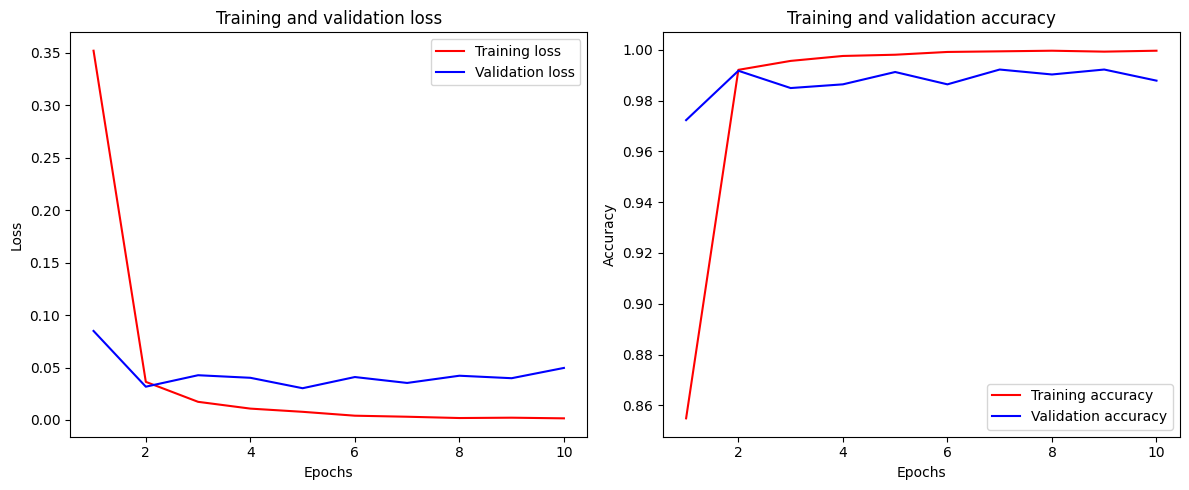

In [22]:
# Menampilkan grafik history
def plot_history(history):
    # Mengambil nilai loss dan akurasi dari history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Menghitung jumlah epoch
    epochs = range(1, len(loss) + 1)

    # Plotting loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'r', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Menampilkan grafik
    plt.tight_layout()
    plt.show()

plot_history(history)

Dar grafik di atas dapat kita lihat bahwa model bekerja dengan baik pada pelatihan kedua dan mencapai kinerja terbaik pada pelatihan ke-5.

In [23]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Akurasi pada data uji: {accuracy:.4f}')

65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9915 - loss: 0.0380
Akurasi pada data uji: 0.9879


In [24]:
# Predict on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype("int32")

65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step


Berdasarkan classification report di bawah, dapat dipahami hal berikut tentang model:
*   Nilai presisi dan recall yang tinggi di kedua label menandakan bahwa model memiliki keseimbangan yang baik antara mendeteksi tweet yang benar-benar mengandung tanda-tanda depresi dan menghindari kesalahan klasifikasi.
* Skor F1 dari masing-masing label yang tinggi menunjukkan bahwa model memiliki performa yang konsisten dan dapat diandalkan dalam situasi yang memerlukan keseimbangan antara precision dan recal



In [25]:
# Generate classification report
report = classification_report(y_test, y_pred, target_names=['Tidak ada tanda depresi', 'Ada tanda depresi'])
print(report)

                         precision    recall  f1-score   support

Tidak ada tanda depresi       0.99      0.99      0.99      1589
      Ada tanda depresi       0.97      0.98      0.97       469

               accuracy                           0.99      2058
              macro avg       0.98      0.98      0.98      2058
           weighted avg       0.99      0.99      0.99      2058



Selanjutnya kita bisa melihat actual label yang disandingkan dengan predicted label untuk melihat lebih jelas kecocokan pada kinerja model.

In [26]:
# Display some sample predictions
sample_data = pd.DataFrame({'Text': tokenizer.sequences_to_texts(X_test[:10]),
                            'Actual Label': y_test[:10],
                            'Predicted Label': y_pred[:10].flatten()})

print(sample_data)

                                                Text  Actual Label  \
0  <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV...             0   
1  <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV...             1   
2  <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV...             0   
3  <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV...             0   
4  <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV...             1   
5  <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV...             0   
6  <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV...             1   
7  <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV...             0   
8  <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV...             0   
9  <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV...             0   

   Predicted Label  
0                0  
1                1  
2                0  
3                0  
4                1  
5                0  
6                1  
7                0  
8                0  
9                0 

Evaluasi model juga dibuat dengan
menggunakan matriks kebingungan
(confusion matriks).


*   Jumlah true positive (ada tanda depresi dan diklasifikasikan sebagai ada tanda depresi oleh model) berjumlah 460.
* Jumlah false positive (ada tanda depresi namun tidak diklasifikasikan sebagai ada tanda depresi oleh model) berjumlah 9.
* Jumlah true negative (tidak ada tanda depresi dan diklasifikasikan sebagai tidak ada tanda depresi oleh model) berjumlah 1579.
* Jumlah false negative (tidak ada tanda
depresi namun diklasifikasikan sebagai ada tanda depresi oleh model) berjumlah 10.



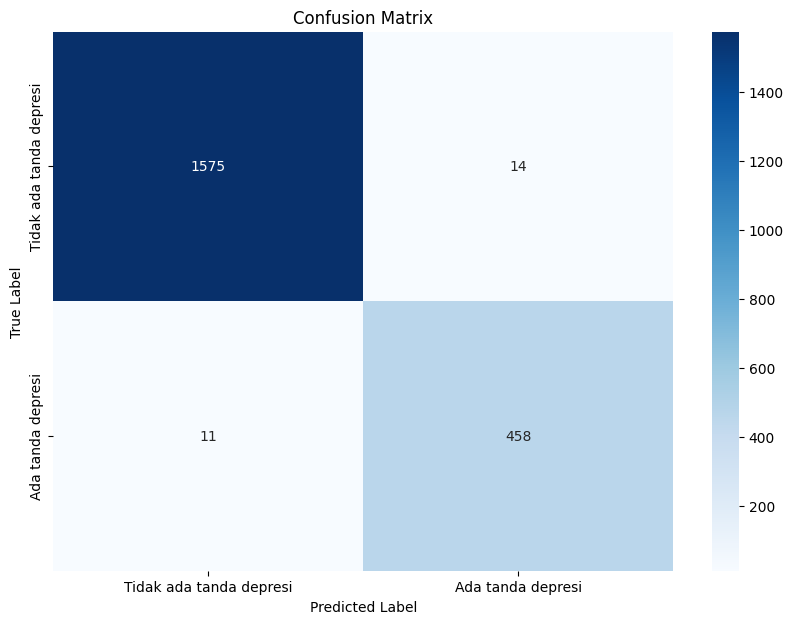

In [31]:
# Menampilkan matriks kebingungan
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Tidak ada tanda depresi', 'Ada tanda depresi'], yticklabels=['Tidak ada tanda depresi', 'Ada tanda depresi'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Prediksi Data Baru

Di sini, kami mencoba memasukkan data baru untuk melihat apakah model bisa memprediksi data baru.

In [28]:
# Mendefinisikan fungsi prediksi sentimen baru
def predict_sentiment(text):
    # Preprocessing teks
    processed_text = preprocess_text(text)

    # Tokenisasi dan padding
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, truncating=trunc_type)

    # Prediksi
    prediction = model.predict(padded_sequence)

    # Mengubah probabilitas menjadi label
    sentiment = 'Ada tanda depresi' if prediction[0] < 0.5 else 'Tidak ada tanda depresi'
    return sentiment

In [29]:
new_text = "I feel super sad and lonely"
sentiment = predict_sentiment(new_text)
print(f'Sentimen dari teks baru: {sentiment}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Sentimen dari teks baru: Ada tanda depresi


### Menyimpan Model

In [34]:
# Save the model into H5
from tensorflow.keras.models import save_model

model.save('TweetSentimentAnalysis.h5')